In [1]:
import os
import glob
from math import ceil

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg

%load_ext autoreload
%autoreload 2

In [2]:
results_dir = os.path.join(
    cfg.repo_root, '08_cell_line_prediction', 'results', 'tcga_ccle_nn_lr_range'
)

num_genes = 8000
seed = 42
plot_gene = 'KRAS'

In [3]:
lc_dfs = {}

for lc_file in glob.glob(
    os.path.join(results_dir,
                 plot_gene,
                 f'{plot_gene}_signal_mad_s{seed}_n{num_genes}_lr*_classify_learning_curves.tsv.gz')
):
    learning_rate = (
        os.path.basename(lc_file).split('_')[5].replace('lr', '')
    )
    lc_df = pd.read_csv(lc_file, sep='\t', index_col=0).reset_index(drop=True)
    lc_df['learning_rate'] = learning_rate
    lc_dfs[learning_rate] = lc_df

print(list(lc_dfs.keys()))
lc_dfs[list(lc_dfs.keys())[0]].head()

['0.0005', '0.00025', '0.0001', '1e-06', '5e-05', '1e-05', '0.01', '0.005', '0.001']


,epoch,fold,dataset,metric,value,learning_rate
0,1,0,train,aupr,0.594870,0.0005
1,2,0,train,aupr,0.813569,0.0005
2,3,0,train,aupr,0.903578,0.0005
3,4,0,train,aupr,0.943436,0.0005
4,5,0,train,aupr,0.973287,0.0005


[1e-06, 1e-05, 5e-05, 0.0001, 0.00025, 0.0005, 0.001, 0.005, 0.01]


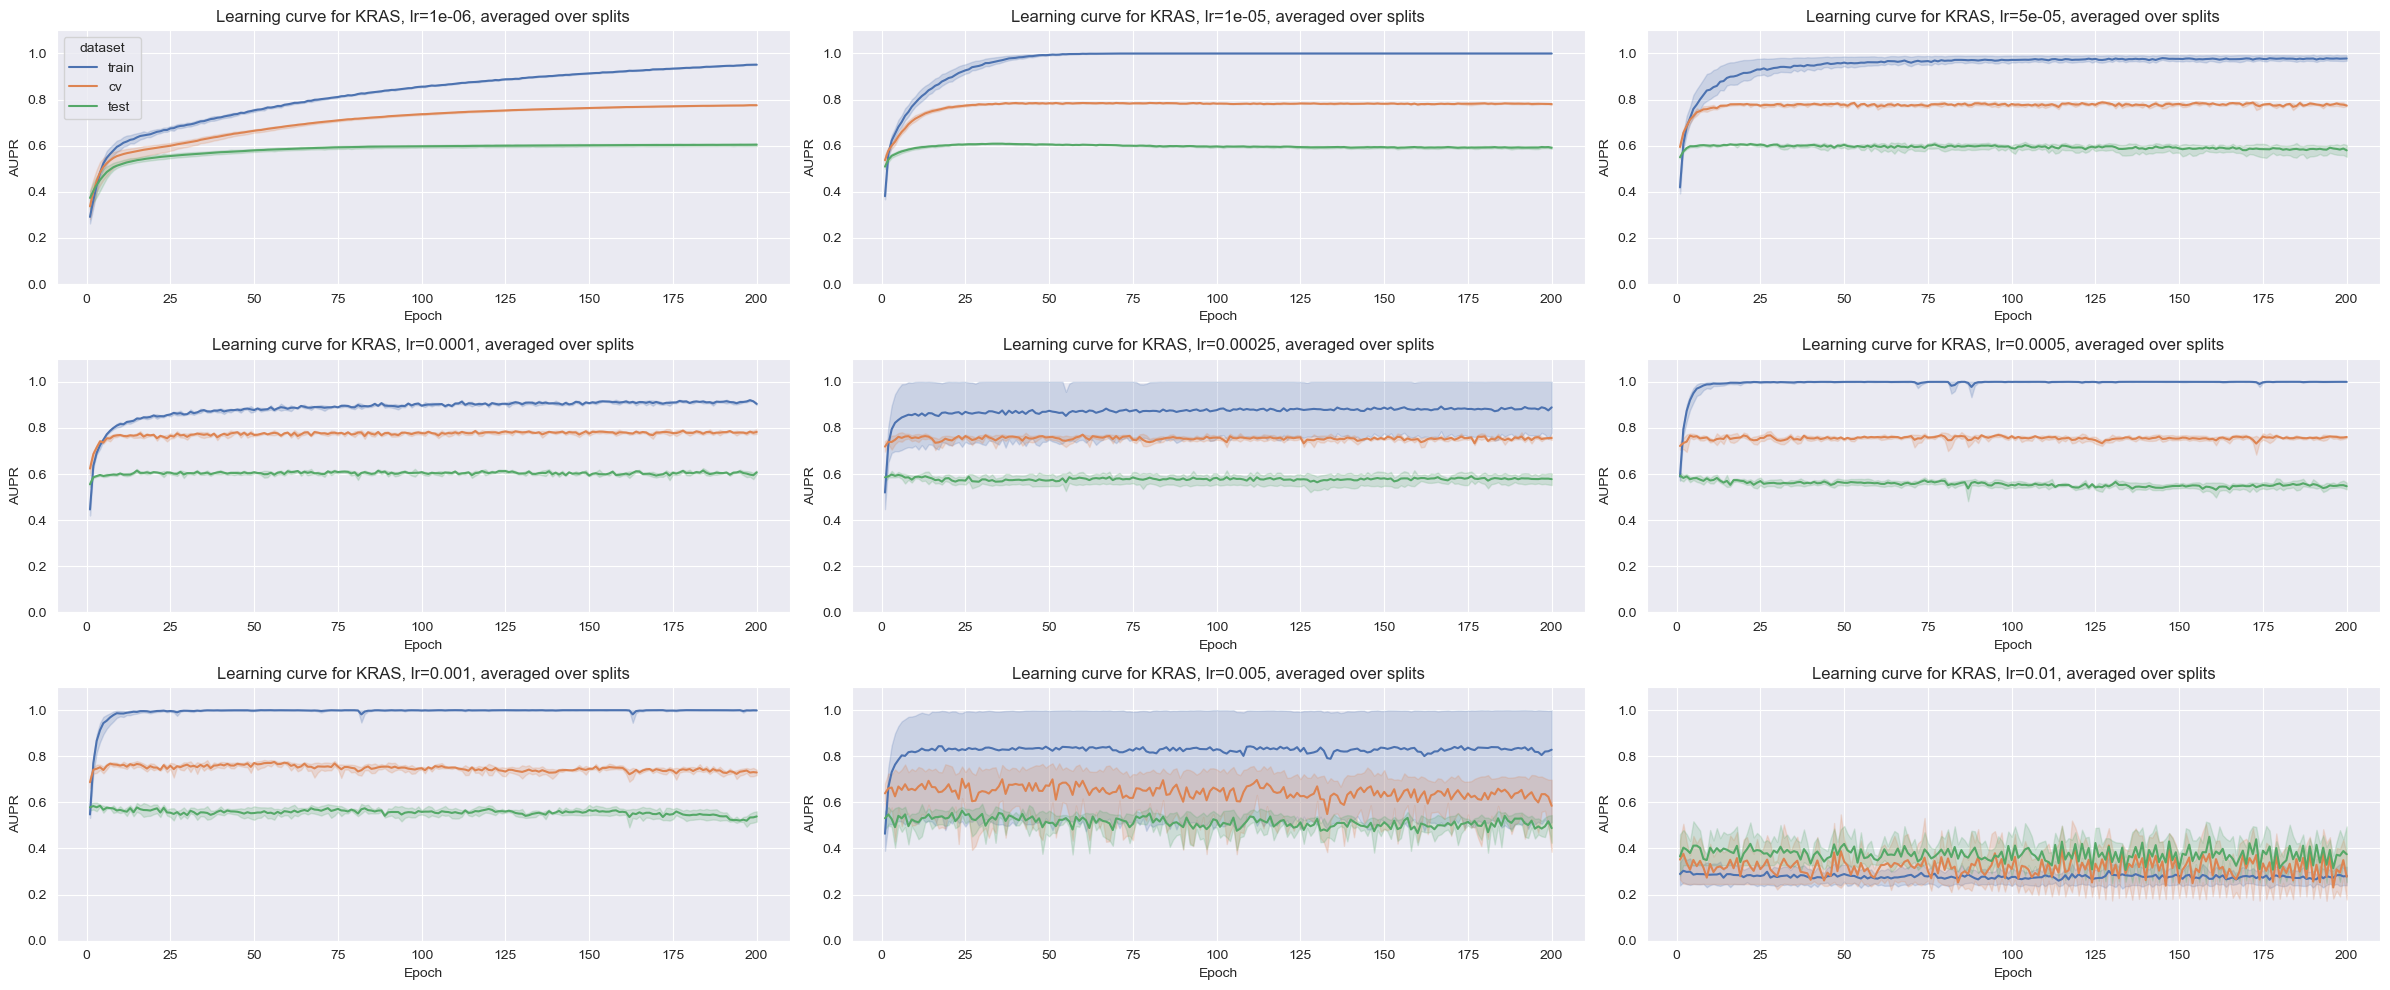

In [4]:
sns.set_style('whitegrid')
sns.set({'figure.figsize': (24, 10)})

learning_rates = sorted(list([float(k) for k in lc_dfs.keys()]))
print(learning_rates)

fig, axarr = plt.subplots(ceil(len(learning_rates) / 3), 3)

for ix, lr in enumerate(learning_rates):
    ax = axarr[ix // 3, ix % 3]
    if ix == 0:
        sns.lineplot(data=lc_dfs[str(lr)], x='epoch', y='value', hue='dataset', ax=ax)
    else:
        sns.lineplot(data=lc_dfs[str(lr)], x='epoch', y='value', hue='dataset', legend=False, ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('AUPR')
    ax.set_ylim(0, 1.1)
    ax.set_title(f'Learning curve for {plot_gene}, lr={lr}, averaged over splits')
    
plt.tight_layout()

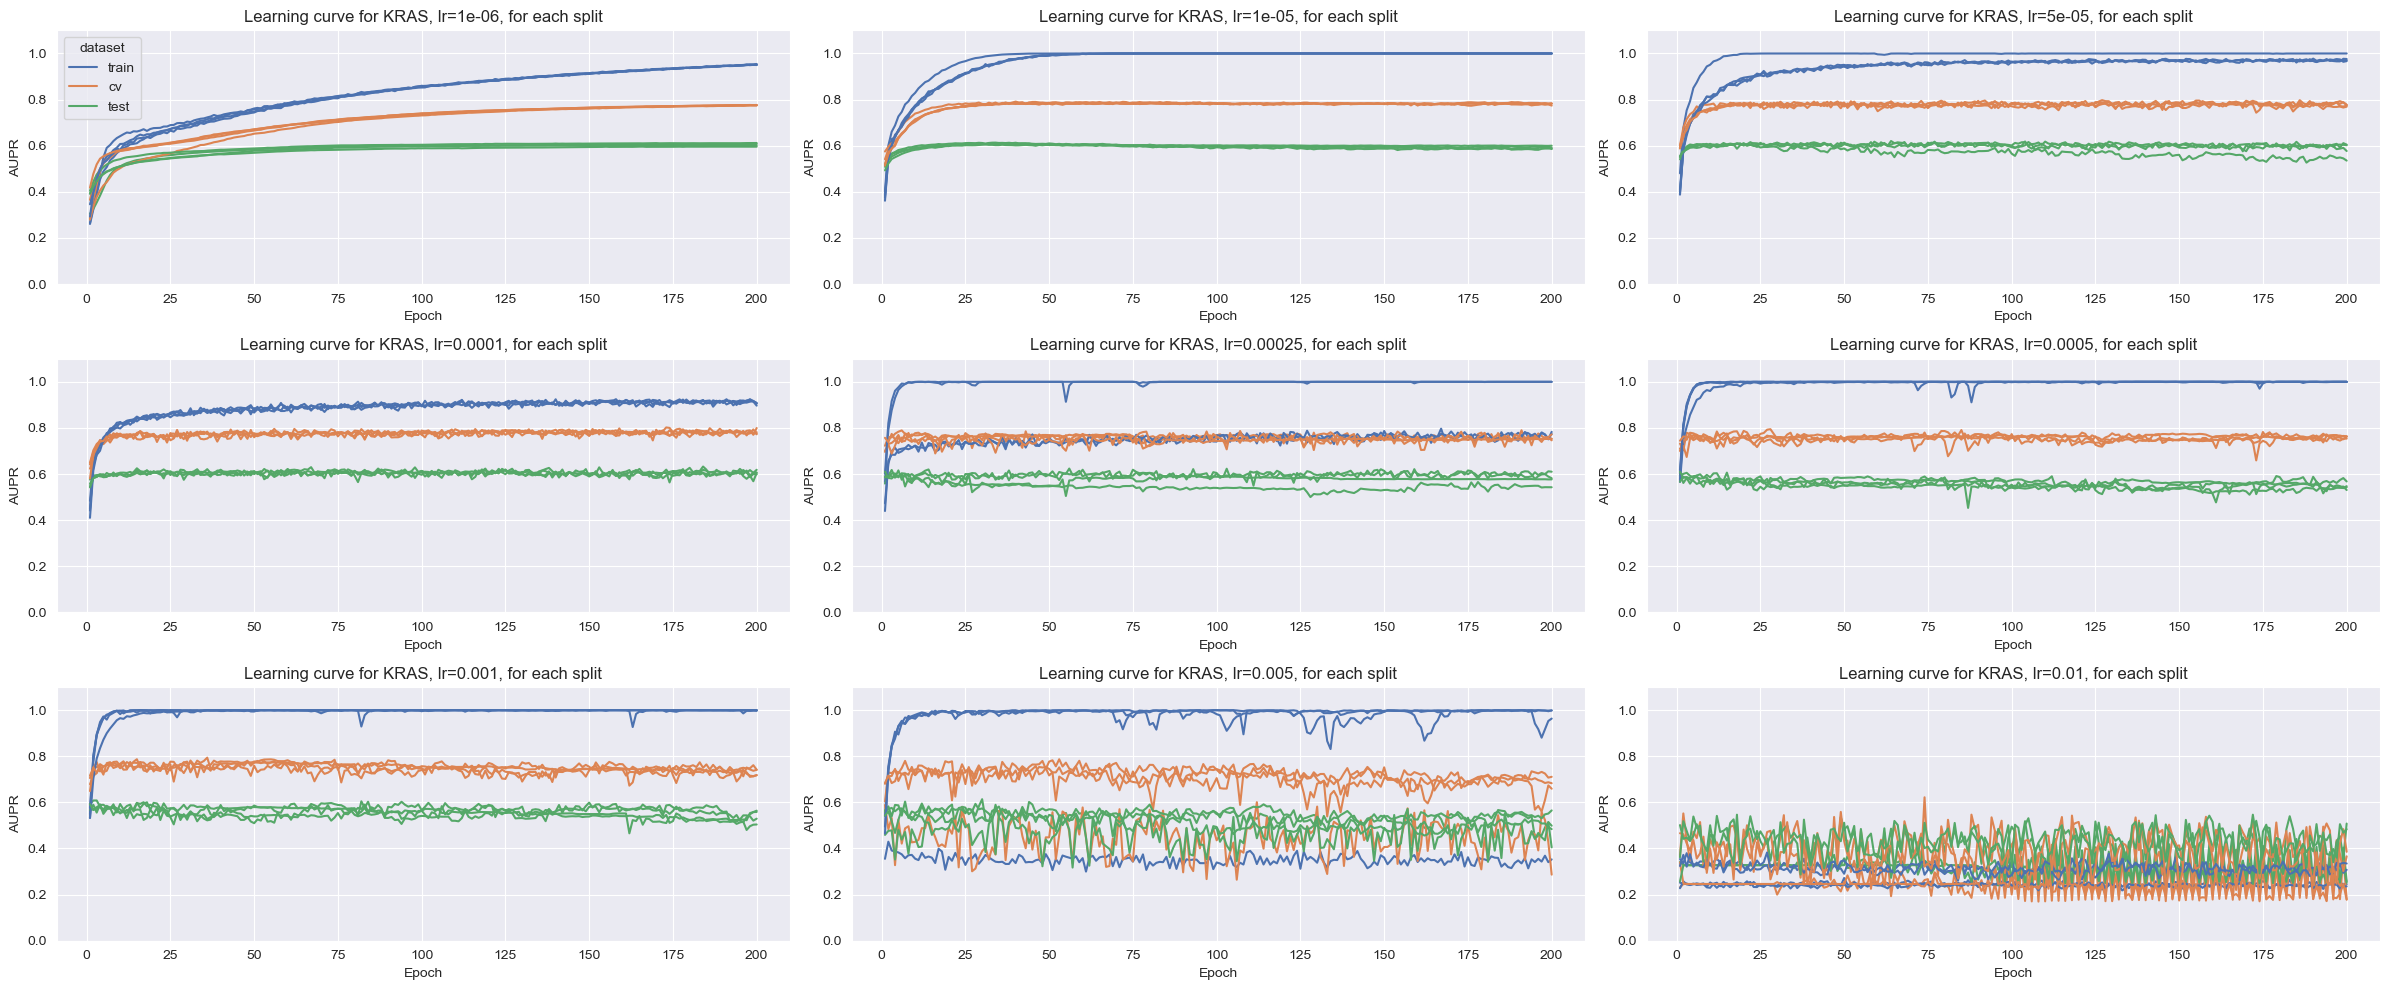

In [5]:
sns.set_style('whitegrid')
sns.set({'figure.figsize': (24, 10)})

fig, axarr = plt.subplots(ceil(len(learning_rates) / 3), 3)

for lr_ix, lr in enumerate(learning_rates):
    ax = axarr[lr_ix // 3, lr_ix % 3]
    lc_df = lc_dfs[str(lr)]
    for fold_ix, fold in enumerate(lc_df.fold.unique()):
        if lr_ix == 0 and fold_ix == 0:
            sns.lineplot(data=lc_df[lc_df.fold == fold],
                         x='epoch', y='value', hue='dataset', ax=ax)
        else:
            sns.lineplot(data=lc_df[lc_df.fold == fold],
                         x='epoch', y='value', hue='dataset',
                         legend=False, ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('AUPR')
    ax.set_ylim(0, 1.1)
    ax.set_title(f'Learning curve for {plot_gene}, lr={lr}, for each split')

plt.tight_layout()

In [6]:
lr_df = pd.concat(lc_dfs.values())
print(lr_df.shape)
lr_df.head()

(21600, 6)


,epoch,fold,dataset,metric,value,learning_rate
0,1,0,train,aupr,0.594870,0.0005
1,2,0,train,aupr,0.813569,0.0005
2,3,0,train,aupr,0.903578,0.0005
3,4,0,train,aupr,0.943436,0.0005
4,5,0,train,aupr,0.973287,0.0005


In [7]:
last_epoch = lr_df.epoch.max()
perf_df = (lr_df[lr_df.epoch == last_epoch]
    .drop(columns=['epoch'])
)
                      
print(perf_df.shape)
perf_df.head()

(108, 5)


,fold,dataset,metric,value,learning_rate
199,0,train,aupr,1.000000,0.0005
399,0,cv,aupr,0.761885,0.0005
599,0,test,aupr,0.542412,0.0005
799,1,train,aupr,0.999325,0.0005
999,1,cv,aupr,0.753807,0.0005


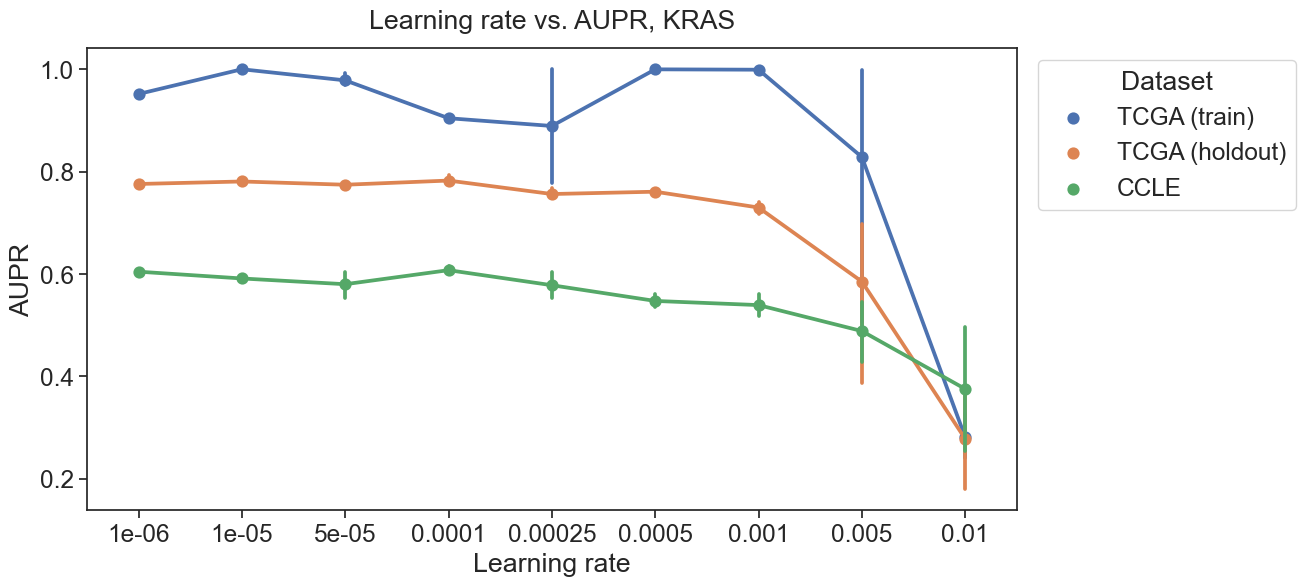

In [8]:
# plot weight decay as a categorical variable vs. performance
sns.set({'figure.figsize': (12, 6)})
sns.set_style('ticks')

plot_df = (perf_df
    .sort_values(by=['learning_rate'])
    .reset_index(drop=True)
)
plot_df.learning_rate = plot_df.learning_rate.astype(float)

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.pointplot(
        data=plot_df,
        x='learning_rate', y='value', hue='dataset',
        hue_order=['train', 'cv', 'test'],
        marker='o'
    )
    g.set_xlabel(f'Learning rate')
    g.set_ylabel('AUPR')
        
    ax = plt.gca()
    legend_handles, _ = ax.get_legend_handles_labels()
    dataset_labels = ['TCGA (train)', 'TCGA (holdout)', 'CCLE'] 
    ax.legend(legend_handles, dataset_labels, title='Dataset')
    sns.move_legend(g, "upper left", bbox_to_anchor=(1.01, 1))
    plt.title(f'Learning rate vs. AUPR, {plot_gene}', y=1.025)

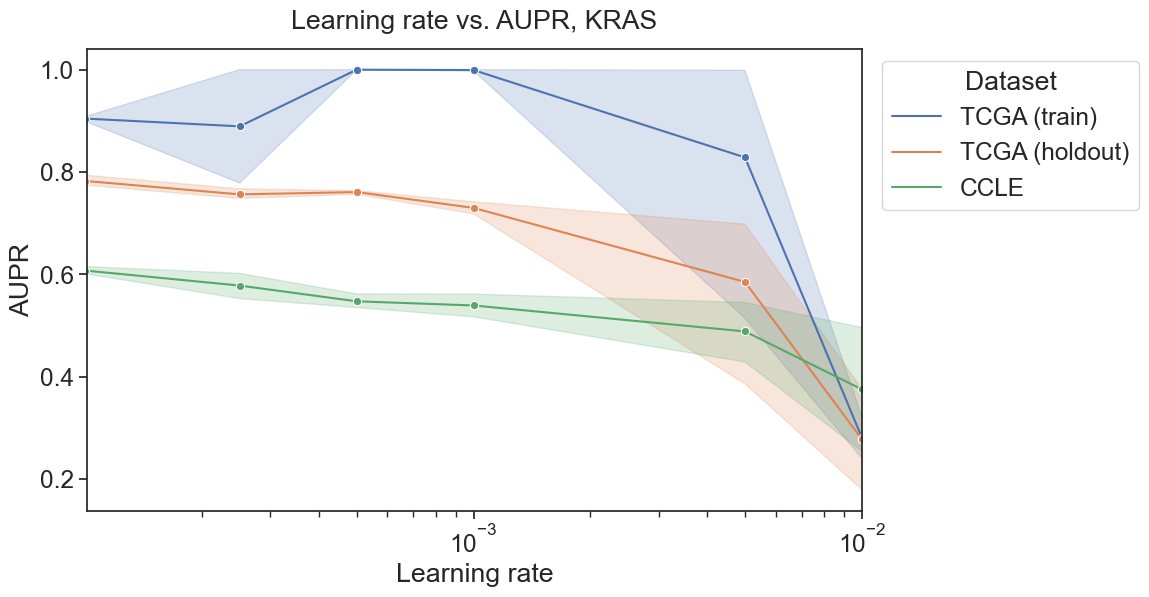

In [9]:
# plot learning rate as a float-valued variable (on a log scale) vs. performance
sns.set({'figure.figsize': (10, 6)})
sns.set_style('ticks')

plot_df = (perf_df
    .sort_values(by=['learning_rate'])
    .reset_index(drop=True)
)
plot_df.learning_rate = plot_df.learning_rate.astype(float)

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.lineplot(
        data=plot_df,
        x='learning_rate', y='value', hue='dataset',
        hue_order=['train', 'cv', 'test'],
        marker='o'
    )
    g.set(xscale='log', xlim=(min(plot_df.learning_rate) + 0.0001, max(plot_df.learning_rate)))
    g.set_xlabel(f'Learning rate')
    g.set_ylabel('AUPR')
        
    ax = plt.gca()
    legend_handles, _ = ax.get_legend_handles_labels()
    dataset_labels = ['TCGA (train)', 'TCGA (holdout)', 'CCLE'] 
    ax.legend(legend_handles, dataset_labels, title='Dataset')
    sns.move_legend(g, "upper left", bbox_to_anchor=(1.01, 1))
    plt.title(f'Learning rate vs. AUPR, {plot_gene}', y=1.025)